In [161]:
import os

from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchinfo
import torchvision

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split

from torchinfo import summary

import copy

from torchvision import datasets, models, transforms
from tqdm import tqdm


In [109]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124
torchinfo version :  1.8.0
numpy version :  1.26.4
matplotlib version :  3.7.2
Python 3.11.11


In [110]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [111]:
data_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'

print("Data Directory:", data_dir)

Data Directory: /kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer


In [112]:
classes = os.listdir(data_dir)

print("List of classes:", classes)

List of classes: ['brain_tumor', 'brain_glioma', 'brain_menin']


In [113]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [114]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

In [115]:
dataset = datasets.ImageFolder(data_dir,transform=transform)

print('Length of dataset:', len(dataset))

Length of dataset: 6056


In [116]:
dataset_loader = DataLoader(dataset,batch_size=32,shuffle=False,num_workers=2)

In [117]:
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for data, _ in tqdm(loader,desc='Calculating Mean & Std'):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [118]:
mean, std = compute_mean_std(dataset_loader)
print("Mean:", mean)
print("Std:", std)

Calculating Mean & Std: 100%|██████████| 190/190 [00:31<00:00,  6.11it/s]

Mean: tensor([0.1543, 0.1543, 0.1543])
Std: tensor([0.1668, 0.1668, 0.1668])


In [119]:
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [120]:
dataset_norm = datasets.ImageFolder(data_dir,transform=transform_norm)

In [122]:
# Initial split: 80% train, 20% val_test
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_test_dataset = random_split(dataset_norm, lengths=[0.8, 0.2], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of val+test dataset:", len(val_test_dataset),'\n')

# Secondary split: 50% val, 50% test
val_dataset, test_dataset = random_split(val_test_dataset, lengths=[0.5, 0.5], generator=g)

print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset),'\n')

# Percentages
total_len = len(dataset_norm)
percent_train = np.round(100 * len(train_dataset) / total_len, 1)
percent_val = np.round(100 * len(val_dataset) / total_len, 1)
percent_test = np.round(100 * len(test_dataset) / total_len, 1)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")
print(f"Test data is {percent_test}% of full data")


Length of training dataset: 4845
Length of val+test dataset: 1211 

Validation set size: 606
Test set size: 605 

Train data is 80.0% of full data
Validation data is 10.0% of full data
Test data is 10.0% of full data


In [123]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

100%|██████████| 4845/4845 [00:16<00:00, 288.24it/s]


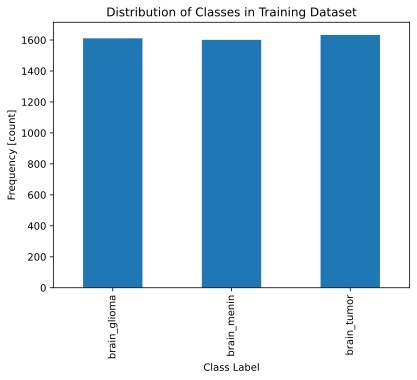

In [124]:
train_counts = class_counts(train_dataset)

# Make a bar chart from the function output
train_counts.plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

100%|██████████| 1211/1211 [00:04<00:00, 287.05it/s]


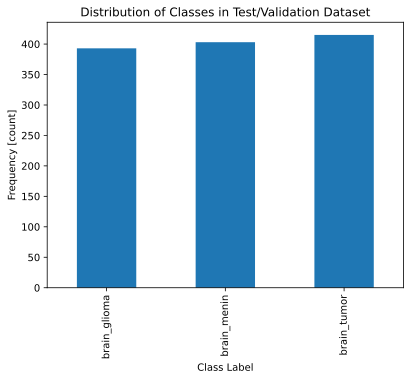

In [125]:
val_test_counts = class_counts(val_test_dataset)

# Make a bar chart from the function output
val_test_counts.plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Test/Validation Dataset");

In [126]:
batch_size = 32

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2,pin_memory=True)

print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [127]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [128]:
for p in model.parameters():
    p.requires_grad = False
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [129]:
in_features = model.classifier.in_features

modified_classification_layer = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 3)
)

model.classifier = modified_classification_layer

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [130]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(),weight_decay=5e-4)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0005
)


In [131]:
# Place model on device
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [132]:
height = 512
width = 512

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [32, 3]                   --
├─Sequential: 1-1                        [32, 1024, 16, 16]        --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        (9,408)
│    └─BatchNorm2d: 2-2                  [32, 64, 256, 256]        (128)
│    └─ReLU: 2-3                         [32, 64, 256, 256]        --
│    └─MaxPool2d: 2-4                    [32, 64, 128, 128]        --
│    └─_DenseBlock: 2-5                  [32, 256, 128, 128]       --
│    │    └─_DenseLayer: 3-1             [32, 32, 128, 128]        (45,440)
│    │    └─_DenseLayer: 3-2             [32, 32, 128, 128]        (49,600)
│    │    └─_DenseLayer: 3-3             [32, 32, 128, 128]        (53,760)
│    │    └─_DenseLayer: 3-4             [32, 32, 128, 128]        (57,920)
│    │    └─_DenseLayer: 3-5             [32, 32, 128, 128]        (62,080)
│    │    └─_DenseLayer: 3-6             [32, 3

In [142]:
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min', 
                              patience=2, 
                              factor=0.5, )

In [144]:
def train(model,
          train_loader,
          val_loader,
          optimizer,
          loss_fn,
          epochs=10,
          device='cpu',
          patience=3,
          scheduler=None,  # Optional learning rate scheduler
          save_path='best_model.pth'
         ):

    model.to(device)

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    trainAcc = []
    valAcc = []
    trainLoss = torch.zeros(epochs)
    valLoss = torch.zeros(epochs)

    for epoch in range(1, epochs + 1):
        print(f"\n🔁 Epoch {epoch}/{epochs}")

        train_batchAcc = []
        train_batchLoss = []

        model.train()
        for X, y in tqdm(train_loader, desc='Training', leave=False):
            X, y = X.to(device), y.to(device)

            yHat = model(X)
            loss = loss_fn(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_batchAcc.append(100 * torch.mean((torch.argmax(yHat, dim=1) == y).float()).item())
            train_batchLoss.append(loss.item())

        trainAcc.append(np.mean(train_batchAcc))
        trainLoss[epoch - 1] = np.mean(train_batchLoss)

        print(f"✅ Training Loss: {trainLoss[epoch - 1]:.4f} | Training Accuracy: {trainAcc[-1]:.2f}%")

        # Validation phase
        model.eval()
        val_batchAcc = []
        val_batchLoss = []

        with torch.no_grad():
            for X, y in tqdm(val_loader, desc='Validating', leave=False):
                X, y = X.to(device), y.to(device)
                yHat = model(X)
                loss = loss_fn(yHat, y)

                val_batchAcc.append(100 * torch.mean((torch.argmax(yHat, dim=1) == y).float()).item())
                val_batchLoss.append(loss.item())

        valAcc.append(np.mean(val_batchAcc))
        valLoss[epoch - 1] = np.mean(val_batchLoss)

        print(f"🔎 Validation Loss: {valLoss[epoch - 1]:.4f} | Validation Accuracy: {valAcc[-1]:.2f}%")

        # Learning rate scheduling
        if scheduler:
            scheduler.step(valLoss[epoch - 1])

        # Checkpointing
        if valAcc[-1] > best_val_acc:
            best_val_acc = valAcc[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f"💾 Best model saved with validation accuracy: {best_val_acc:.2f}%")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"⏳ No improvement. Early stop counter: {early_stop_counter}/{patience}")

        # Early stopping
        if early_stop_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model,trainAcc, trainLoss, valAcc, valLoss


In [146]:
# Train
model,trainAcc, trainLoss, valAcc, valLoss = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    epochs=20,
    device=device,
    scheduler=scheduler,
    patience=5,
    save_path='/kaggle/working/best_model.pth'
)


🔁 Epoch 1/20


✅ Training Loss: 0.2041 | Training Accuracy: 92.58%


🔎 Validation Loss: 0.1234 | Validation Accuracy: 95.56%
💾 Best model saved with validation accuracy: 95.56%

🔁 Epoch 2/20


✅ Training Loss: 0.1919 | Training Accuracy: 92.92%


🔎 Validation Loss: 0.1250 | Validation Accuracy: 95.38%
⏳ No improvement. Early stop counter: 1/5

🔁 Epoch 3/20


✅ Training Loss: 0.1902 | Training Accuracy: 92.77%


🔎 Validation Loss: 0.1261 | Validation Accuracy: 95.55%
⏳ No improvement. Early stop counter: 2/5

🔁 Epoch 4/20


✅ Training Loss: 0.1658 | Training Accuracy: 94.06%


🔎 Validation Loss: 0.1152 | Validation Accuracy: 96.22%
💾 Best model saved with validation accuracy: 96.22%

🔁 Epoch 5/20


✅ Training Loss: 0.1840 | Training Accuracy: 93.12%


🔎 Validation Loss: 0.1277 | Validation Accuracy: 95.56%
⏳ No improvement. Early stop counter: 1/5

🔁 Epoch 6/20


✅ Training Loss: 0.1548 | Training Accuracy: 94.28%


🔎 Validation Loss: 0.1236 | Validation Accuracy: 95.70%
⏳ No improvement. Early stop counter: 2/5

🔁 Epoch 7/20


✅ Training Loss: 0.1612 | Training Accuracy: 94.13%


🔎 Validation Loss: 0.1324 | Validation Accuracy: 94.89%
⏳ No improvement. Early stop counter: 3/5

🔁 Epoch 8/20


✅ Training Loss: 0.1437 | Training Accuracy: 94.40%


🔎 Validation Loss: 0.1203 | Validation Accuracy: 95.38%
⏳ No improvement. Early stop counter: 4/5

🔁 Epoch 9/20


✅ Training Loss: 0.1337 | Training Accuracy: 95.08%


🔎 Validation Loss: 0.1198 | Validation Accuracy: 95.88%
⏳ No improvement. Early stop counter: 5/5
⛔ Early stopping triggered.


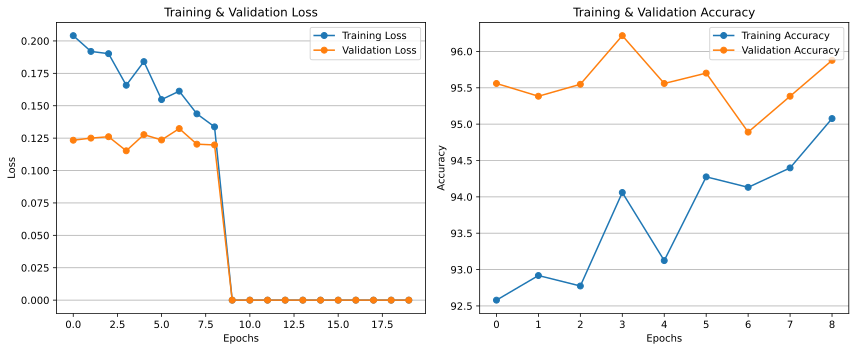

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax[0].plot(trainLoss, 'o-', label="Training Loss")
ax[0].plot(valLoss, 'o-', label="Validation Loss")
ax[0].set_title("Training & Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(axis='y')

# Plot training and validation accuracy
ax[1].plot(trainAcc, 'o-', label="Training Accuracy")
ax[1].plot(valAcc, 'o-', label="Validation Accuracy")
ax[1].set_title("Training & Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(axis='y') 

plt.tight_layout()
plt.show()

In [153]:
def predict(model, data_loader, device="cpu"):
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=True):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [154]:
batch_size = 32

test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2,pin_memory=True)

In [157]:
test_probabilities = predict(model,test_loader,device)
test_predictions = torch.argmax(test_probabilities,dim=1)

print(test_predictions)

Predicting: 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]


tensor([1, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 2, 1,
        2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 2, 0, 1, 2,
        1, 2, 1, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 0, 2, 2, 0, 2, 1, 2, 1, 1, 2, 1,
        0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0,
        2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 2, 2, 2,
        2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 2, 1, 2, 0, 1,
        0, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 0, 0,
        1, 2, 0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2,
        1, 1, 2, 2, 1, 0, 0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0,
        0, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 0, 0, 1, 2, 0, 2, 2, 1, 0, 0, 1, 1, 2,
        0, 1, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 2, 2, 2, 1, 2, 0, 0, 1, 0,
        1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 0,

Get Labels: 100%|██████████| 19/19 [00:03<00:00,  5.95it/s]


<Figure size 1000x800 with 0 Axes>

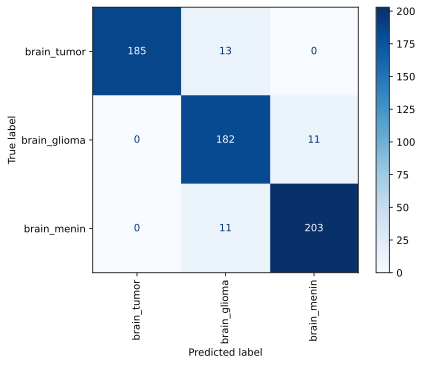

In [160]:
targets_test = torch.cat([labels for _, labels in tqdm(test_loader, desc="Get Labels")])

cm = confusion_matrix(targets_test.cpu(), test_predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.savefig('/kaggle/working/ConfusionMatrix');

In [162]:
class_report = classification_report(targets_test.cpu(), test_predictions.cpu())

print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.97       198
           1       0.88      0.94      0.91       193
           2       0.95      0.95      0.95       214

    accuracy                           0.94       605
   macro avg       0.94      0.94      0.94       605
weighted avg       0.94      0.94      0.94       605



In [ ]:
plt.imshow()